# 利用MindQuantum解决组合优化问题

In [1]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Looking in links: https://obs-workspace-20180810.obs.cn-north-1.myhuaweicloud.com/pypi/index.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import networkx as nx

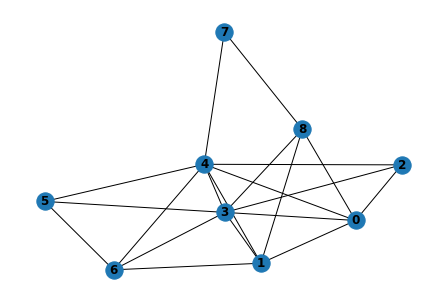

In [3]:
g = nx.gnm_random_graph(9, 20, seed=42)
nx.draw(g,with_labels=True, font_weight='bold')

In [4]:
print(list(g.edges))

[(0, 1), (0, 8), (0, 2), (0, 4), (0, 3), (1, 8), (1, 6), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (3, 8), (3, 6), (3, 5), (4, 7), (4, 5), (4, 6), (5, 6), (7, 8)]


## nx库中的解法

In [5]:
cut, partition = nx.algorithms.approximation.one_exchange(g)
print(cut, partition)

14 ({8, 3, 4}, {0, 1, 2, 5, 6, 7})


## Try to solve by yourself

In [6]:
def solution(edges):
    pass

In [7]:
my_cut = solution(list(g.edges))
print(f'I get {my_cut} cuts')

I get None cuts


## QAOA

In [8]:
from mindquantum import *

In [9]:
depth = 9
ansatz = MaxCutAnsatz(list(g.edges), depth)

ham = ansatz.hamiltonian
circuit = ansatz.circuit
circuit

q0: ──H────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)─────────────────────────────────────────────────────────────ZZ(beta_1)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)─────────────────────────────────────────────────────────────ZZ(beta_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)─────────────────────────────────────────────────────────────ZZ(beta_3)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────RX(alpha_3)─────────────────────────────────────────────────────────────ZZ(beta_4)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_4)────ZZ(beta_4)────ZZ(beta_4)────ZZ(beta_4)────RX(alpha_4)─────────────────────────────────────────────────────────────ZZ(beta_5)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_5)────ZZ(beta_5)────ZZ(beta_5)────ZZ(beta_5)────RX(alpha_5)─────────────────────────────────────────────────────────────ZZ(beta_6)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_6)────ZZ(beta_6)────ZZ(beta_6)────ZZ(beta_6)────RX(alpha_6)─────────────────────────────────────────────────────────────ZZ(beta_7)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_7)────ZZ(beta_7)────ZZ(beta_7)────ZZ(beta_7)────RX(alpha_7)─────────────────────────────────────────────────────────────ZZ(beta_8)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_8)────ZZ(beta_8)────ZZ(beta_8)────ZZ(beta_8)────RX(alpha_8)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │             │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                     │                                                                                                                                                │             │             │             │                                                                                  

In [10]:
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(-ham), circuit)

In [11]:
import numpy as np

grad_ops(np.random.random(size=len(circuit.params_name)))

(array([[-10.18373271-2.83135015e-17j]]),
 array([[[-2.41332702e-01+0.j,  1.01298133e+00+0.j, -1.29169034e-01+0.j,
           8.61278826e-01+0.j, -1.82215235e-01+0.j, -5.55573989e-01+0.j,
           1.65846050e-01+0.j, -2.65884068e-01+0.j, -8.14716700e-05+0.j,
          -2.96991180e-02+0.j, -4.61809706e-01+0.j, -2.23948731e-02+0.j,
          -4.47231331e-01+0.j,  3.02979032e-01+0.j, -1.94156832e+00+0.j,
           3.77401076e-01+0.j, -1.80490665e+00+0.j,  2.39719593e-01+0.j]]]))

### 利用`scipy`的优化器进行优化

In [12]:
from scipy.optimize import minimize

def fun(x):
    f, g = grad_ops(x)
    print(f"Cut value: {-f.real[0, 0]}")
    return f.real[0, 0], g.real[0, 0]

np.random.seed(1)
x0 = np.random.random(len(circuit.params_name))
optimizers = ['cg', 'COBYLA', 'Powell', 'bfgs']
opti = optimizers[1]
tol = 1e-6
res = minimize(fun, x0, method=opti, jac=True, tol=tol)

Cut value: 9.209969483001858
Cut value: 8.669883236921814
Cut value: 9.81537417447807
Cut value: 9.630192043160697
Cut value: 9.91758883238413
Cut value: 9.569412378426291
Cut value: 9.57397166766325
Cut value: 9.448622357118563
Cut value: 9.912813738402495
Cut value: 8.480156817425614
Cut value: 10.122459606719783
Cut value: 9.582712717579078
Cut value: 10.1232353053902
Cut value: 9.557183876115896
Cut value: 9.77785857340692
Cut value: 9.83012184028076
Cut value: 9.800234092952799
Cut value: 9.68796353377494
Cut value: 10.15384166957514
Cut value: 10.654071310912535
Cut value: 10.036678035302465
Cut value: 9.672495930444448
Cut value: 9.24895960836285
Cut value: 9.713265341460005
Cut value: 9.986529235681939
Cut value: 10.153788629006893
Cut value: 8.330275012807855
Cut value: 8.782223227346526
Cut value: 10.33428280824694
Cut value: 10.537452981636518
Cut value: 7.165936127244969
Cut value: 6.59308878671412
Cut value: 10.557882701956402
Cut value: 10.901284798249545
Cut value: 12.05

In [13]:
def get_partitions(theta, first_n=1):
    s = Simulator('projectq', circuit.n_qubits)
    s.apply_circuit(circuit, dict(zip(circuit.params_name, theta)))
    state = s.get_qs()
    amp = np.abs(state)**2
    partitions=[]
    for n in range(first_n):
        poi = np.argmax(amp)
        amp[poi] = -1
        bin_string = bin(poi)[2:].zfill(circuit.n_qubits)[::-1]
        partition = [[], []]
        for i, j in enumerate(bin_string):
            partition[int(j)].append(i)
        partitions.append(partition)
    return partitions

def get_cut_value(graph, partitions):
    values = []
    for partition in partitions:
        value = 0
        for p0 in partition[0]:
            for p1 in partition[1]:
                for g in graph:
                    if p0 in g and p1 in g:
                        value += 1
        values.append(value)
    return values

In [14]:
partitions = get_partitions(res.x, 6)
for i, j in enumerate(partitions):
    print(f'partition {i}: {j}')

partition 0: [[1, 2, 4, 5, 8], [0, 3, 6, 7]]
partition 1: [[0, 3, 6, 7], [1, 2, 4, 5, 8]]
partition 2: [[3, 4, 8], [0, 1, 2, 5, 6, 7]]
partition 3: [[0, 1, 2, 5, 6, 7], [3, 4, 8]]
partition 4: [[2, 4, 6, 8], [0, 1, 3, 5, 7]]
partition 5: [[0, 1, 3, 5, 7], [2, 4, 6, 8]]


In [15]:
cut_values = get_cut_value(g.edges, partitions)
print(f'cut values: {cut_values}')
print(f'\nYour configuration:\ndepth: {depth}\nmethod: {opti}\ntol: {tol}\nstep: {res.nfev}')

cut values: [14, 14, 14, 14, 14, 14]

Your configuration:
depth: 9
method: COBYLA
tol: 1e-06
step: 1000
